In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            f'\tFixed Point: {config.FIXED_POINT}.\n' +
            f'\tFuse BN: {config.FUSE_BN}.\n' +
            f'\tWeights bit width = {config.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config.BIAS_BIT_WIDTH}.\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

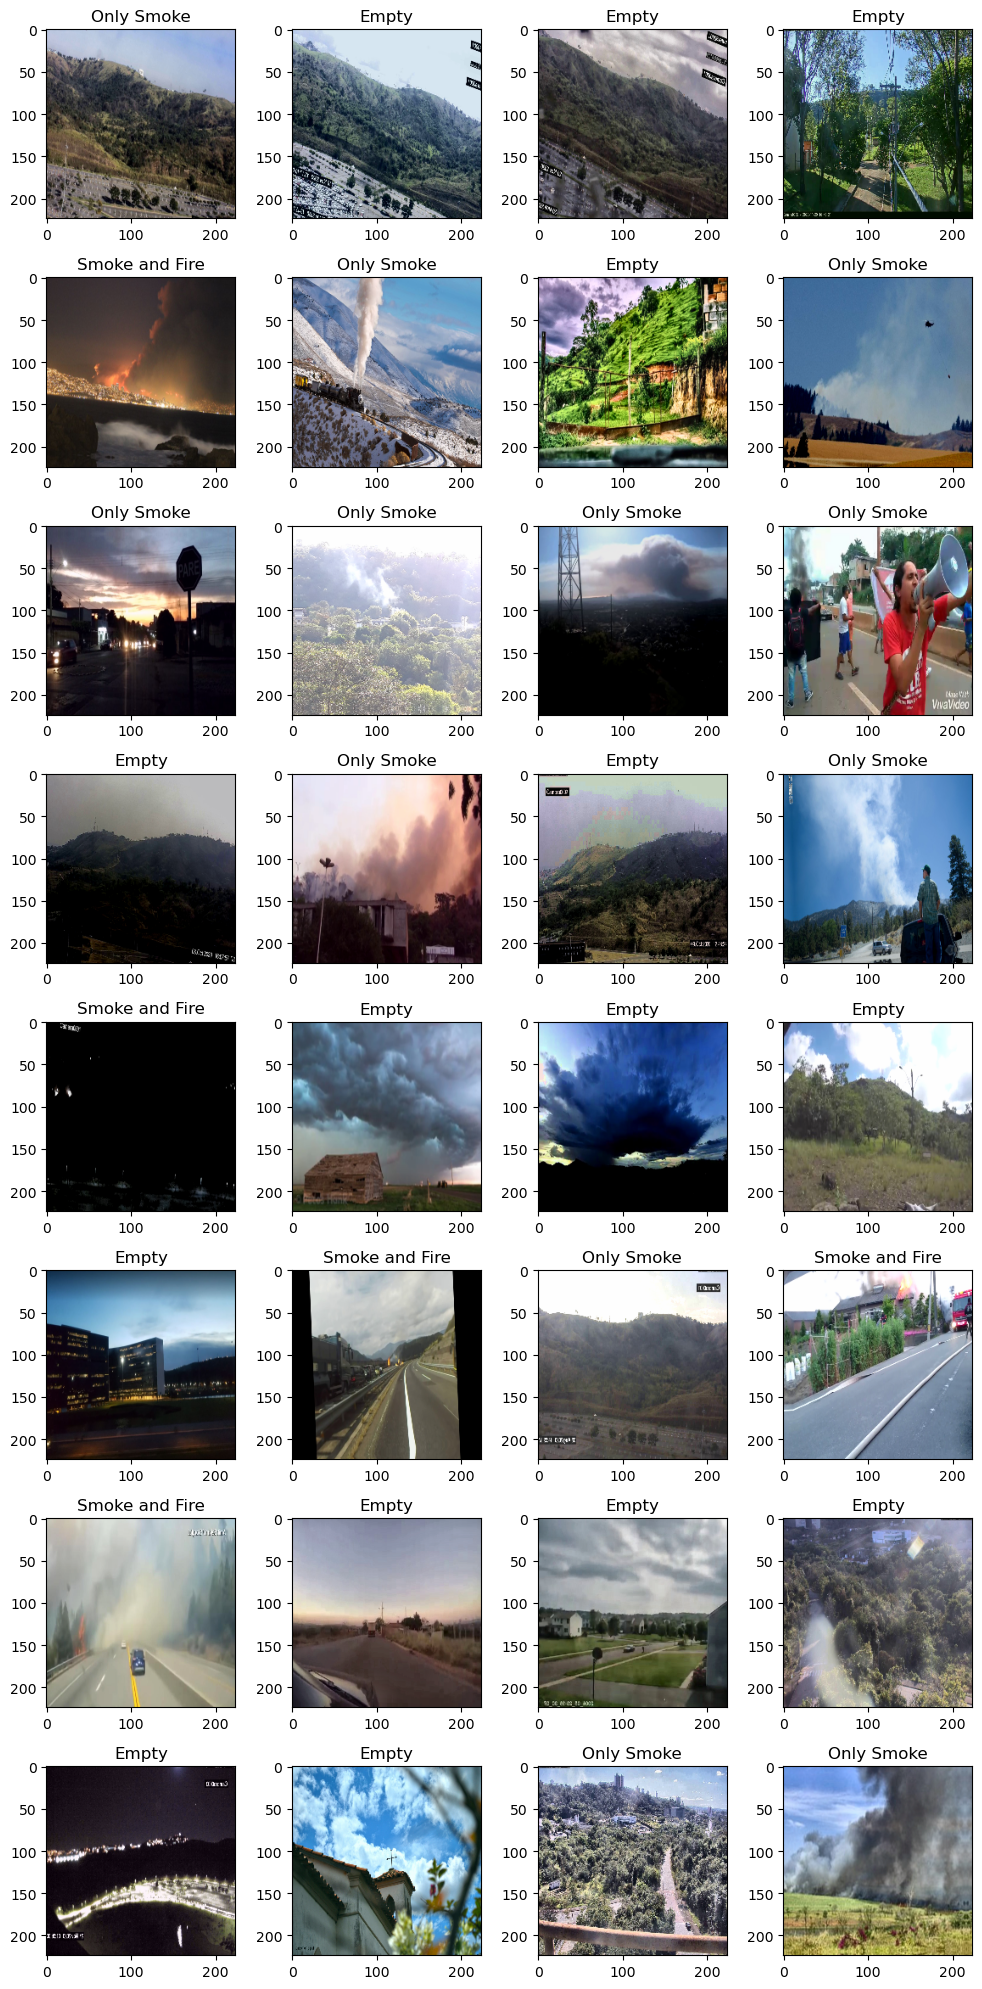

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

In [8]:
if config.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
    
    if config.FIXED_POINT == True and config.FUSE_BN == False:
        print("Using Fixed Point Quantizers with BN")
        logger.info("Using Fixed Point Quantizers with BN")
        quant_model = models.QUANT_FixedPoint_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    elif config.FIXED_POINT == True and config.FUSE_BN == True:
        print("Using Fixed Point Quantizers without BN")
        logger.info("Using Fixed Point Quantizers without BN")
        quant_model = models.QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                big_layers_weight_bw = config.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    else:
        quant_model = models.QUANT_BED_CLASSIFIER(
            weight_bw = config.WEIGHTS_BIT_WIDTH,
            act_bw = config.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config.BIAS_BIT_WIDTH,
            num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 93297
Total parameters = 93297



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[0.1551, 0.0382],
        [0.1526, 0.0373],
        [0.1546, 0.0366],
        [0.1566, 0.0353]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clamp_min_

# Load Pretrained or Initialize Weights

In [10]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config.FACTOR, 
    patience=config.PATIENCE, 
    threshold=config.THRES, 
    threshold_mode='abs',
    min_lr=config.MIN_LR)

if config.LOAD_MODEL == False:
    if config.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 127 epochs


# Torchinfo: model summary

### Quant Model

In [11]:
print(summary(quant_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                                                      Output Shape              Param #
QUANT_FixedPoint_NoBN_BED_CLASSIFIER                                        [64, 2]                   --
├─Sequential: 1-1                                                           [64, 2]                   --
│    └─QuantIdentity: 2-1                                                   [64, 3, 224, 224]         --
│    │    └─ActQuantProxyFromInjector: 3-1                                  [64, 3, 224, 224]         --
│    │    └─ActQuantProxyFromInjector: 3-2                                  [64, 3, 224, 224]         --
│    └─QuantReLU: 2-55                                                      --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-99                                 --                        (recursive)
│    └─QuantIdentity: 2-3                                                   --                        --
│    │    └─ActQuantProxyFromInj

### FP32 Model

In [12]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        32
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Load Pretrained Weights from FP32 Model to Quant Model

In [13]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Fuse Conv2d and BatchNorm first if needed

In [14]:
if config.FUSE_BN == True:
    
    modules_to_fuse = [ 
        ["model.conv1", "model.bn1"],
        ["model.conv2", "model.bn2"],
        ["model.conv31", "model.bn31"],
        ["model.conv32", "model.bn32"],
        ["model.conv33", "model.bn33"],
        ["model.conv34", "model.bn34"],
        ["model.conv41", "model.bn41"],
        ["model.conv42", "model.bn42"],
        ["model.conv43", "model.bn43"],
        ["model.conv44", "model.bn44"],
        ["model.conv45", "model.bn45"],
        ["model.conv46", "model.bn46"]
    ]

    fp32_model.eval()
    torch.ao.quantization.fuse_modules(fp32_model, modules_to_fuse, inplace=True)  

In [15]:
if config.FUSE_BN == True:
    print("Print Model again after BN Fusion")
    print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
    logger.info("FP32 Model afte BatchNorm Fusion Summary")
    logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Print Model again after BN Fusion
Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─Identity: 2-2                     [64, 32, 224, 224]        --
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,624
│    └─Identity: 2-7                     [64, 16, 112, 112]        --
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 1

### Load all Pretrained Weights

In [16]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.BatchNorm2d):
                if fp32_name == quant_name:
                    if config.FUSE_BN == False:
                        quant_mod.load_state_dict(fp32_mod.state_dict())
                        print(f'\t****** Loading weights of BN layer fp32 {fp32_name} into quant {quant_name}')
                    else:
                        print(f'\t______ BN should never print here, as Fused Model should not have such layers')    
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	****** Loading weights of Conv2d layer fp32 model.conv2 into quant model.conv2
fp32 model name: model.relu2 - quant model name: mod

# Loss Function

In [17]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [18]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [19]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [20]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [21]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 13:00:14


=== EPOCH 0/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:37<00:00,  1.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.195      |28.755      |17.440      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.585      |21.845      |9.740       
SMOKE -> Precision: 0.919 - Recall: 0.651 - Accuracy: 0.805 - F1: 0.762
FIRE -> Precision: 0.940 - Recall: 0.850 - Accuracy: 0.947 - F1: 0.893

Saving model with new best validation loss: 31.585
Saving model with best Mean F1: 0.8274

=== EPOCH 1/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.998      |22.433      |10.565      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.495      |17.996      |8.499       
SMOKE -> Precision: 0.893 - Recall: 0.811 - Accuracy: 0.862 - F1: 0.850
FIRE -> Precision: 0.943 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.908

Saving model with new best validation loss: 26.495
Saving model with best Mean F1: 0.8789

=== EPOCH 2/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.492      |21.444      |10.048      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.551      |18.062      |8.489       
SMOKE -> Precision: 0.915 - Recall: 0.764 - Accuracy: 0.852 - F1: 0.833
FIRE -> Precision: 0.913 - Recall: 0.915 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 3/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.461      |20.678      |9.783       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.375      |16.190      |8.184       
SMOKE -> Precision: 0.884 - Recall: 0.869 - Accuracy: 0.882 - F1: 0.876
FIRE -> Precision: 0.965 - Recall: 0.857 - Accuracy: 0.955 - F1: 0.908

Saving model with new best validation loss: 24.375
Saving model with best Mean F1: 0.8921

=== EPOCH 4/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.258      |20.009      |9.248       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.023      |16.999      |8.025       
SMOKE -> Precision: 0.860 - Recall: 0.899 - Accuracy: 0.881 - F1: 0.879
FIRE -> Precision: 0.960 - Recall: 0.863 - Accuracy: 0.955 - F1: 0.909
Saving model with best Mean F1: 0.8938

=== EPOCH 5/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.654      |20.019      |9.635       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.511      |16.645      |7.866       
SMOKE -> Precision: 0.895 - Recall: 0.848 - Accuracy: 0.879 - F1: 0.871
FIRE -> Precision: 0.939 - Recall: 0.892 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 6/49 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.220      |19.678      |9.542       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.235      |16.430      |8.805       
SMOKE -> Precision: 0.909 - Recall: 0.830 - Accuracy: 0.878 - F1: 0.868
FIRE -> Precision: 0.970 - Recall: 0.839 - Accuracy: 0.951 - F1: 0.900

=== EPOCH 7/49 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.053      |19.222      |8.831       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.176      |16.401      |7.775       
SMOKE -> Precision: 0.865 - Recall: 0.915 - Accuracy: 0.890 - F1: 0.889
FIRE -> Precision: 0.947 - Recall: 0.892 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 24.176
Saving model with best Mean F1: 0.9041

=== EPOCH 8/49 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.391      |19.403      |8.988       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.985      |16.658      |8.327       
SMOKE -> Precision: 0.873 - Recall: 0.889 - Accuracy: 0.884 - F1: 0.881
FIRE -> Precision: 0.969 - Recall: 0.859 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 9/49 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.341      |19.391      |8.950       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.370      |17.248      |8.123       
SMOKE -> Precision: 0.899 - Recall: 0.822 - Accuracy: 0.870 - F1: 0.859
FIRE -> Precision: 0.962 - Recall: 0.869 - Accuracy: 0.957 - F1: 0.913

=== EPOCH 10/49 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.947      |18.967      |8.980       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.816      |16.711      |8.105       
SMOKE -> Precision: 0.855 - Recall: 0.927 - Accuracy: 0.889 - F1: 0.889
FIRE -> Precision: 0.968 - Recall: 0.861 - Accuracy: 0.957 - F1: 0.911

=== EPOCH 11/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.641      |18.973      |8.668       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.834      |15.947      |8.887       
SMOKE -> Precision: 0.907 - Recall: 0.849 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.970 - Recall: 0.838 - Accuracy: 0.951 - F1: 0.899

=== EPOCH 12/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.088      |19.106      |8.982       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.731      |16.141      |7.589       
SMOKE -> Precision: 0.867 - Recall: 0.922 - Accuracy: 0.895 - F1: 0.894
FIRE -> Precision: 0.958 - Recall: 0.875 - Accuracy: 0.958 - F1: 0.914

Saving model with new best validation loss: 23.731
Saving model with best Mean F1: 0.9041

=== EPOCH 13/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.494      |18.714      |8.780       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.893      |15.300      |7.593       
SMOKE -> Precision: 0.899 - Recall: 0.888 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.949 - Recall: 0.896 - Accuracy: 0.961 - F1: 0.922

Saving model with new best validation loss: 22.893
Saving model with best Mean F1: 0.9078

=== EPOCH 14/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.404      |18.889      |8.515       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.236      |15.908      |7.328       
SMOKE -> Precision: 0.866 - Recall: 0.933 - Accuracy: 0.899 - F1: 0.898
FIRE -> Precision: 0.952 - Recall: 0.906 - Accuracy: 0.964 - F1: 0.928
Saving model with best Mean F1: 0.9135

=== EPOCH 15/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.089      |18.564      |8.525       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.876      |15.313      |7.563       
SMOKE -> Precision: 0.885 - Recall: 0.905 - Accuracy: 0.898 - F1: 0.895
FIRE -> Precision: 0.963 - Recall: 0.869 - Accuracy: 0.958 - F1: 0.914

Saving model with new best validation loss: 22.876

=== EPOCH 16/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.414      |18.738      |8.676       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.003      |15.292      |7.711       
SMOKE -> Precision: 0.901 - Recall: 0.873 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.966 - Recall: 0.868 - Accuracy: 0.958 - F1: 0.914

=== EPOCH 17/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.508      |18.715      |8.793       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.203      |15.525      |7.678       
SMOKE -> Precision: 0.905 - Recall: 0.868 - Accuracy: 0.893 - F1: 0.886
FIRE -> Precision: 0.948 - Recall: 0.899 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 18/49 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.810      |18.418      |8.392       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.467      |15.830      |7.637       
SMOKE -> Precision: 0.913 - Recall: 0.840 - Accuracy: 0.884 - F1: 0.875
FIRE -> Precision: 0.962 - Recall: 0.880 - Accuracy: 0.960 - F1: 0.919

=== EPOCH 19/49 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.085      |18.352      |8.733       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.813      |17.131      |7.682       
SMOKE -> Precision: 0.911 - Recall: 0.819 - Accuracy: 0.874 - F1: 0.862
FIRE -> Precision: 0.957 - Recall: 0.877 - Accuracy: 0.958 - F1: 0.915

=== EPOCH 20/49 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.095      |18.465      |8.630       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.187      |15.269      |7.918       
SMOKE -> Precision: 0.903 - Recall: 0.871 - Accuracy: 0.893 - F1: 0.886
FIRE -> Precision: 0.972 - Recall: 0.859 - Accuracy: 0.957 - F1: 0.912

=== EPOCH 21/49 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.760      |18.370      |8.390       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.550      |15.875      |7.676       
SMOKE -> Precision: 0.865 - Recall: 0.928 - Accuracy: 0.896 - F1: 0.895
FIRE -> Precision: 0.967 - Recall: 0.872 - Accuracy: 0.959 - F1: 0.917

=== EPOCH 22/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:28<00:00,  9.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.818      |18.307      |8.511       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.889      |15.129      |7.760       
SMOKE -> Precision: 0.892 - Recall: 0.898 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.956 - Recall: 0.875 - Accuracy: 0.957 - F1: 0.913

=== EPOCH 23/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.652      |18.224      |8.428       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.830      |16.439      |7.390       
SMOKE -> Precision: 0.857 - Recall: 0.938 - Accuracy: 0.895 - F1: 0.895
FIRE -> Precision: 0.953 - Recall: 0.905 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 24/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.026      |18.429      |8.597       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.687      |14.974      |7.713       
SMOKE -> Precision: 0.898 - Recall: 0.887 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.961 - Recall: 0.876 - Accuracy: 0.959 - F1: 0.917

Saving model with new best validation loss: 22.687

=== EPOCH 25/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.657      |18.317      |8.340       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.784      |16.382      |7.402       
SMOKE -> Precision: 0.911 - Recall: 0.827 - Accuracy: 0.878 - F1: 0.867
FIRE -> Precision: 0.948 - Recall: 0.893 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 26/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.595      |18.234      |8.360       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.953      |15.441      |7.512       
SMOKE -> Precision: 0.906 - Recall: 0.858 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.964 - Recall: 0.876 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 27/49 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.453      |17.998      |8.455       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.375      |15.177      |9.198       
SMOKE -> Precision: 0.916 - Recall: 0.863 - Accuracy: 0.896 - F1: 0.889
FIRE -> Precision: 0.975 - Recall: 0.821 - Accuracy: 0.948 - F1: 0.891

=== EPOCH 28/49 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.782      |17.655      |8.127       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.789      |16.144      |7.644       
SMOKE -> Precision: 0.853 - Recall: 0.945 - Accuracy: 0.896 - F1: 0.897
FIRE -> Precision: 0.972 - Recall: 0.876 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 29/49 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.039      |17.823      |8.215       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.543      |14.980      |7.564       
SMOKE -> Precision: 0.908 - Recall: 0.878 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.962 - Recall: 0.880 - Accuracy: 0.960 - F1: 0.919

Saving model with new best validation loss: 22.543

=== EPOCH 30/49 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.845      |17.731      |8.114       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.915      |14.869      |8.046       
SMOKE -> Precision: 0.889 - Recall: 0.912 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.970 - Recall: 0.858 - Accuracy: 0.956 - F1: 0.911

Saving model with new best smoke precision: 0.889

=== EPOCH 31/49 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.383      |17.862      |8.521       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.566      |15.133      |7.433       
SMOKE -> Precision: 0.904 - Recall: 0.881 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.962 - Recall: 0.883 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 32/49 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.565      |18.123      |8.442       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.695      |15.251      |7.445       
SMOKE -> Precision: 0.877 - Recall: 0.929 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.955 - Recall: 0.892 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 33/49 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.509      |17.380      |8.129       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.099      |14.733      |7.366       
SMOKE -> Precision: 0.901 - Recall: 0.898 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.962 - Recall: 0.886 - Accuracy: 0.962 - F1: 0.923

Saving model with new best validation loss: 22.099

=== EPOCH 34/49 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.765      |17.698      |8.067       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.911      |14.597      |7.314       
SMOKE -> Precision: 0.900 - Recall: 0.900 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.944 - Recall: 0.907 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 21.911

=== EPOCH 35/49 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.160      |17.914      |8.246       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.934      |14.534      |7.400       
SMOKE -> Precision: 0.903 - Recall: 0.902 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.935 - Recall: 0.910 - Accuracy: 0.960 - F1: 0.922

Saving model with new best smoke precision: 0.903

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 36/49 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.740      |17.527      |8.213       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.400      |15.023      |7.377       
SMOKE -> Precision: 0.894 - Recall: 0.903 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.961 - Recall: 0.893 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 37/49 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.792      |17.725      |8.068       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.275      |14.586      |7.688       
SMOKE -> Precision: 0.902 - Recall: 0.899 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.970 - Recall: 0.866 - Accuracy: 0.958 - F1: 0.915

=== EPOCH 38/49 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.647      |17.386      |8.261       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.988      |15.934      |8.054       
SMOKE -> Precision: 0.925 - Recall: 0.816 - Accuracy: 0.880 - F1: 0.867
FIRE -> Precision: 0.972 - Recall: 0.858 - Accuracy: 0.957 - F1: 0.911

=== EPOCH 39/49 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.751      |17.415      |8.336       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.508      |15.190      |9.317       
SMOKE -> Precision: 0.904 - Recall: 0.873 - Accuracy: 0.894 - F1: 0.888
FIRE -> Precision: 0.975 - Recall: 0.821 - Accuracy: 0.948 - F1: 0.891

=== EPOCH 40/49 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.027      |17.729      |8.298       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.040      |15.437      |7.603       
SMOKE -> Precision: 0.891 - Recall: 0.891 - Accuracy: 0.895 - F1: 0.891
FIRE -> Precision: 0.955 - Recall: 0.885 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 41/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.036      |17.094      |7.943       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.588      |17.334      |7.254       
SMOKE -> Precision: 0.930 - Recall: 0.788 - Accuracy: 0.869 - F1: 0.853
FIRE -> Precision: 0.957 - Recall: 0.891 - Accuracy: 0.962 - F1: 0.923

=== EPOCH 42/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.748      |17.505      |8.243       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.177      |14.737      |7.440       
SMOKE -> Precision: 0.893 - Recall: 0.906 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.966 - Recall: 0.870 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 43/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.394      |17.278      |8.116       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.829      |14.658      |7.171       
SMOKE -> Precision: 0.890 - Recall: 0.908 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.969 - Recall: 0.883 - Accuracy: 0.962 - F1: 0.924

Saving model with new best validation loss: 21.829

=== EPOCH 44/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.641      |17.482      |8.159       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.580      |15.011      |7.569       
SMOKE -> Precision: 0.909 - Recall: 0.873 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.960 - Recall: 0.880 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 45/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.934      |17.740      |8.193       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.546      |15.393      |7.153       
SMOKE -> Precision: 0.916 - Recall: 0.847 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.958 - Recall: 0.895 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 46/49 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.700      |17.630      |8.070       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.089      |14.945      |7.144       
SMOKE -> Precision: 0.897 - Recall: 0.898 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.947 - Recall: 0.901 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 47/49 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.509      |17.220      |8.289       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.859      |17.378      |7.480       
SMOKE -> Precision: 0.937 - Recall: 0.789 - Accuracy: 0.873 - F1: 0.856
FIRE -> Precision: 0.961 - Recall: 0.883 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 48/49 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.526      |17.301      |8.225       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.782      |16.615      |8.167       
SMOKE -> Precision: 0.921 - Recall: 0.809 - Accuracy: 0.874 - F1: 0.861
FIRE -> Precision: 0.972 - Recall: 0.855 - Accuracy: 0.956 - F1: 0.910

=== EPOCH 49/49 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.300      |17.084      |8.215       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.721      |14.577      |7.145       
SMOKE -> Precision: 0.891 - Recall: 0.911 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.928 - Recall: 0.920 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 21.721

***Script finished: 13:30:45

Time elapsed: 0:30:31.077988


# Export to ONNX

In [22]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
    export_path=config.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Inference example

In [23]:
quant_model.eval()
ex_in = torch.randn((1, 3, 224, 224)).to(config.DEVICE)
ex_out = quant_model(ex_in)
ex_out

tensor([[-0.1621,  0.1934]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
# ex_in_2 = torch.randn((1, 3, 224, 224)).to(config.DEVICE)
# quant_identity = quant_model.model.input0(ex_in_2)

# Another ONNX Export option

In [25]:
from brevitas.export import export_qonnx
from brevitas.export import export_onnx_qop

In [26]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qop.onnx')

In [27]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qonnx.onnx')